# Customer Churn Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Mobile Customer Departure**_

## Setup


Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.

In [15]:
bucket = 'YOUR BUCKET NAME HERE'
prefix = 'sagemaker/workshop/xgboost-churn'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

print('preix and role setup')

preix and role setup


Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

print('imported needed libraries')

imported needed libraries


---
## Data
The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.  Let's download and read that dataset in now:

In [17]:
!wget https://s3.amazonaws.com/sagemaker-workshop/2018_04_southerndatascienceconference/DKD2e_data_sets.zip
!unzip -o DKD2e_data_sets.zip
churn = pd.read_csv('./Data sets/churn.txt')
pd.set_option('display.max_columns', 500)
churn

--2018-12-11 00:22:34--  https://s3.amazonaws.com/sagemaker-workshop/2018_04_southerndatascienceconference/DKD2e_data_sets.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.16.243
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.16.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003616 (980K) [application/zip]
Saving to: ‘DKD2e_data_sets.zip.1’

DKD2e_data_sets.zip 100%[===================>] 980.09K  --.-KB/s    in 0.04s   

2018-12-11 00:22:35 (21.4 MB/s) - ‘DKD2e_data_sets.zip.1’ saved [1003616/1003616]

Archive:  DKD2e_data_sets.zip
 extracting: Data sets/adult.zip     
  inflating: Data sets/cars.txt      
  inflating: Data sets/cars2.txt     
  inflating: Data sets/cereals.CSV   
  inflating: Data sets/churn.txt     
  inflating: Data sets/ClassifyRisk  
  inflating: Data sets/ClassifyRisk - Missing.txt  
 extracting: Data sets/DKD2e data sets.zip  
  inflating: Data sets/nn1.txt       


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False.
6,MA,121,510,355-9993,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False.
7,MO,147,415,329-9001,yes,no,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False.
8,LA,117,408,335-4719,no,no,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False.
9,WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False.


By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

In [18]:
#Execute this command in a cell to see details about the dataset
churn.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [19]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=['object']).columns:
	print(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))

col_0  % observations
State                
AK           0.015602
AL           0.024002
AR           0.016502
AZ           0.019202
CA           0.010201
CO           0.019802
CT           0.022202
DC           0.016202
DE           0.018302
FL           0.018902
GA           0.016202
HI           0.015902
IA           0.013201
ID           0.021902
IL           0.017402
IN           0.021302
KS           0.021002
KY           0.017702
LA           0.015302
MA           0.019502
MD           0.021002
ME           0.018602
MI           0.021902
MN           0.025203
MO           0.018902
MS           0.019502
MT           0.020402
NC           0.020402
ND           0.018602
NE           0.018302
NH           0.016802
NJ           0.020402
NM           0.018602
NV           0.019802
NY           0.024902
OH           0.023402
OK           0.018302
OR           0.023402
PA           0.013501
RI           0.019502
SC           0.018002
SD           0.018002
TN           0.015902
TX        

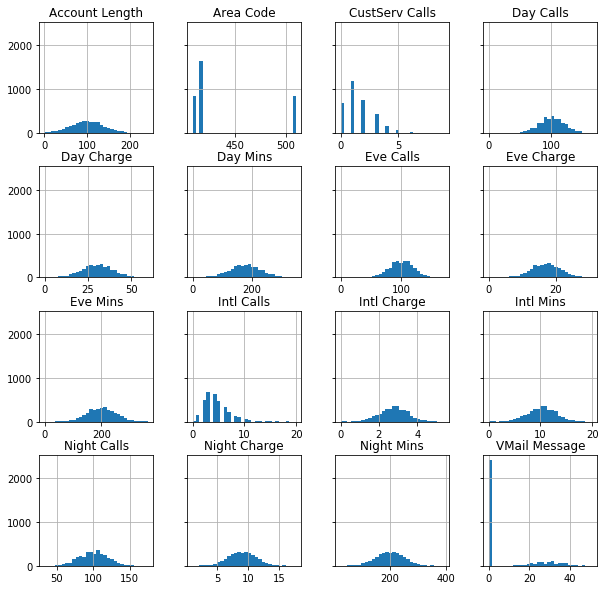

In [20]:
# Histograms for each numeric features
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

In [21]:
churn = churn.drop('Phone', axis=1)
churn['Area Code'] = churn['Area Code'].astype(object)
print('dropped Phone and changed type of Area Code')

dropped Phone and changed type of Area Code


In [22]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        print(pd.crosstab(index=churn[column], columns=churn['Churn?'], normalize='columns'))

Churn?    False.     True.
State                     
AK      0.017193  0.006211
AL      0.025263  0.016563
AR      0.015439  0.022774
AZ      0.021053  0.008282
CA      0.008772  0.018634
CO      0.020000  0.018634
CT      0.021754  0.024845
DC      0.017193  0.010352
DE      0.018246  0.018634
FL      0.019298  0.016563
GA      0.016140  0.016563
HI      0.017544  0.006211
IA      0.014386  0.006211
ID      0.022456  0.018634
IL      0.018596  0.010352
IN      0.021754  0.018634
KS      0.020000  0.026915
KY      0.017895  0.016563
LA      0.016491  0.008282
MA      0.018947  0.022774
MD      0.018596  0.035197
ME      0.017193  0.026915
MI      0.020000  0.033126
MN      0.024211  0.031056
MO      0.019649  0.014493
MS      0.017895  0.028986
MT      0.018947  0.028986
NC      0.020000  0.022774
ND      0.019649  0.012422
NE      0.019649  0.010352
NH      0.016491  0.018634
NJ      0.017544  0.037267
NM      0.019649  0.012422
NV      0.018246  0.028986
NY      0.023860  0.031056
O

Account Length


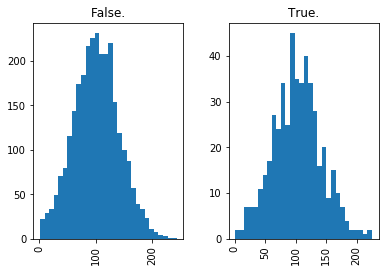

VMail Message


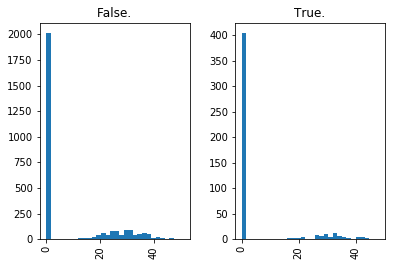

Day Mins


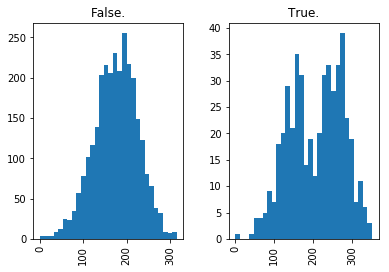

Day Calls


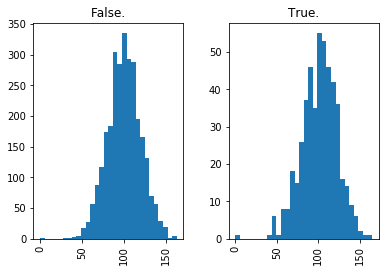

Day Charge


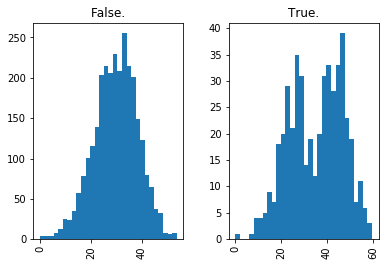

Eve Mins


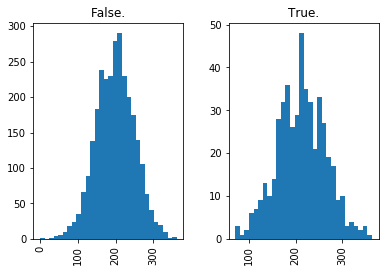

Eve Calls


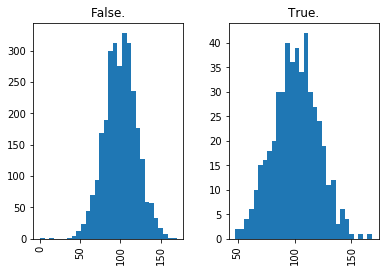

Eve Charge


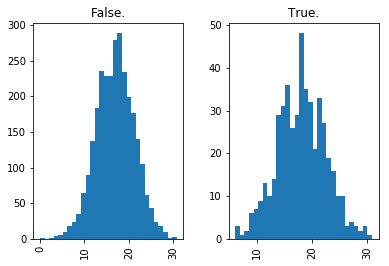

Night Mins


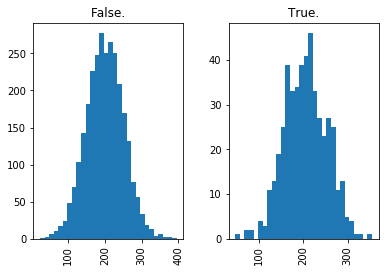

Night Calls


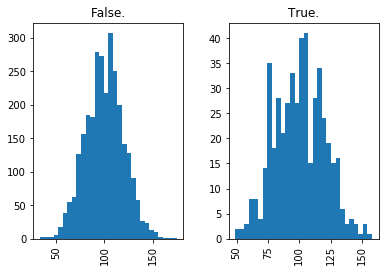

Night Charge


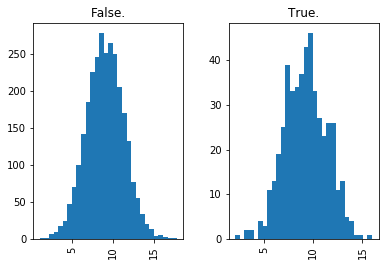

Intl Mins


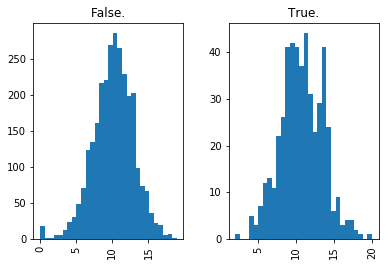

Intl Calls


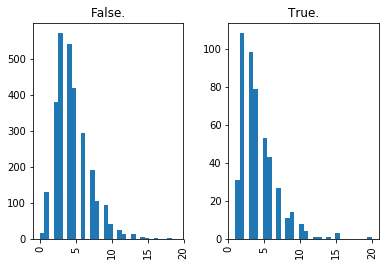

Intl Charge


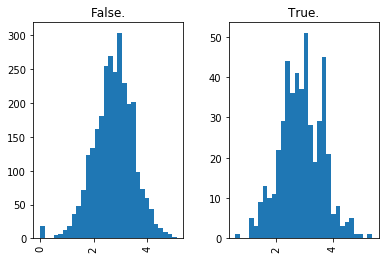

CustServ Calls


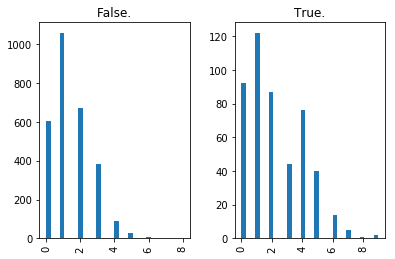

In [23]:
for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = churn[[column, 'Churn?']].hist(by='Churn?', bins=30)
    plt.show()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
VMail Message,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
Day Mins,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
Day Calls,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
Day Charge,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
Eve Mins,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985
Eve Calls,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423
Eve Charge,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987
Night Mins,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288
Night Calls,-0.013176,0.007123,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,0.000305,-0.013630,-0.012802


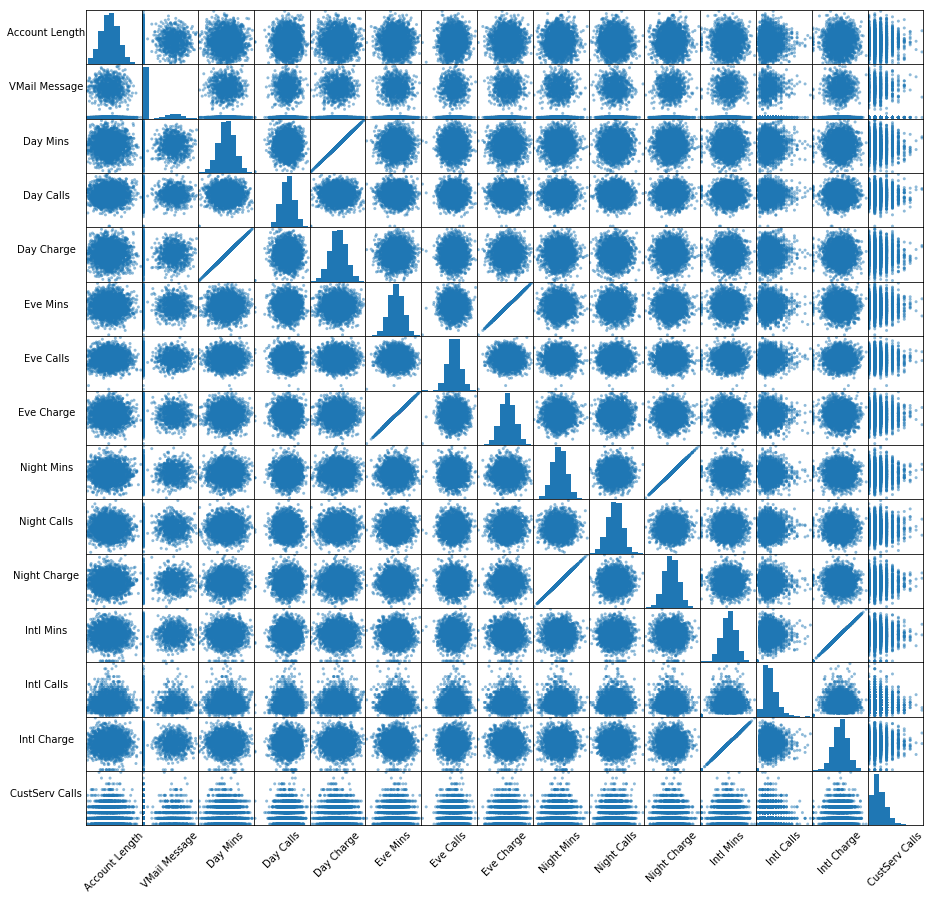

In [24]:
#This code will take a few moments to run, if you see an (*) next to the cell, the code is executing
display(churn.corr())
scatter_matrix = pd.plotting.scatter_matrix(churn, diagonal='hist', figsize=(15, 15))
for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 10, rotation = 45)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 10, rotation = 0, labelpad = 40)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
plt.show()

In [25]:
churn = churn.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

In [26]:
model_data = pd.get_dummies(churn)
model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)

In [27]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [28]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [29]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

INFO:sagemaker:Creating training-job with name: xgboost-2018-12-11-00-23-11-900


2018-12-11 00:23:12 Starting - Starting the training job...
2018-12-11 00:23:15 Starting - Launching requested ML instances......
2018-12-11 00:24:22 Starting - Preparing the instances for training......
2018-12-11 00:25:42 Downloading - Downloading input data
2018-12-11 00:25:42 Training - Downloading the training image...
2018-12-11 00:26:09 Uploading - Uploading generated training model
Arguments: train
[2018-12-11:00:26:03:INFO] Running standalone xgboost training.
[2018-12-11:00:26:03:INFO] File size need to be processed in the node: 0.46mb. Available memory size in the node: 8405.71mb
[2018-12-11:00:26:03:INFO] Determined delimiter of CSV input is ','
[00:26:03] S3DistributionType set as FullyReplicated
[00:26:03] 2333x69 matrix with 160977 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-12-11:00:26:03:INFO] Determined delimiter of CSV input is ','
[00:26:03] S3DistributionType set as FullyReplicated
[00:26:03] 666x69 matrix with 45954 ent

In [30]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-12-11-00-26-54-280
INFO:sagemaker:Creating endpoint with name xgboost-2018-12-11-00-23-11-900


---------------------------------------------------------------!

In [31]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [32]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

In [33]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,282,4
1,9,39


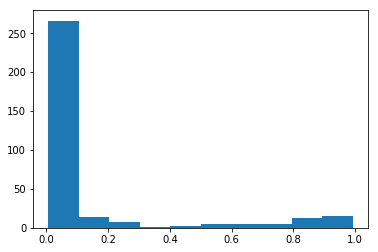

In [34]:
plt.hist(predictions)
plt.show()

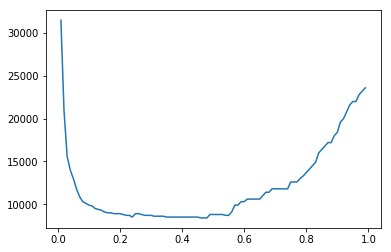

Cost is minimized near a cutoff of: 0.46 for a cost of: 8400


In [35]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * 
                               pd.crosstab(index=test_data.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

In [36]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: xgboost-2018-12-11-00-23-11-900
